In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [3]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Paths for training & validation data. 
# You should create './PatternProject/Train or Validation' folders in your google drive
train_path = '/content/drive/My Drive/PatternProject/Train/' 
valid_path = '/content/drive/My Drive/PatternProject/Validation/'


In [ ]:
# Data Agument:최초 1회만 수행
from PIL import Image
import sys

classes = ['Normal','Fracture']

for i, d in enumerate(classes):
    files = os.listdir(train_path+d)

    for f in files:
        img = Image.open(train_path+d+'/'+f,'r')
        imgLR = img.transpose(Image.FLIP_LEFT_RIGHT)
        imgLR.save(train_path+d+'/'+ f+ 'LR.jpg')
        img.close()
        imgLR.close()
  
        img = Image.open(train_path+d+'/'+f,'r')
        imgLR2 = img.transpose(Image.FLIP_LEFT_RIGHT)
        imgLR90 = imgLR2.transpose(Image.ROTATE_90)
        imgLR90.save(train_path+d+'/'+ f + 'LR90.jpg')
        img.close()
        imgLR90.close()

        img = Image.open(train_path+d+'/'+f,'r')
        imgm90 = img.rotate(270)
        imgm90.save(train_path+d+'/'+ f + '-90.jpg')
        img.close()
        imgm90.close()

        img = Image.open(train_path+d+'/'+f,'r')
        imgTB = img.transpose(Image.FLIP_TOP_BOTTOM)
        imgTB.save(train_path+d+'/'+ f + 'TB.jpg')
        img.close()
        imgTB.close()


In [ ]:
#Prepare training data set
classes = ['Normal','Fracture']

data =[]
label =[]
resize = transforms.Compose([transforms.CenterCrop(400)]) #crop to 400

for i, d in enumerate(classes):
    files = os.listdir(train_path+d)
    
    for f in files:
        img = Image.open(train_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split() # same levels
        one_img = np.asarray(np.float32(r)/255.0) #choose one
        img = np.asarray([one_img])
        data.append(img)
        label.append(i)
        

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:

#Prepare validation data set

data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+d)
    
    for f in files:
        img = Image.open(valid_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split()
        one_img = np.asarray(np.float32(r)/255.0)
        img = np.asarray([one_img])
        data.append(img)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


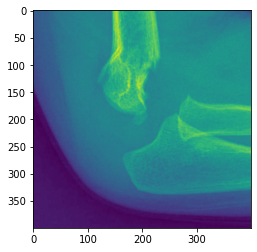

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


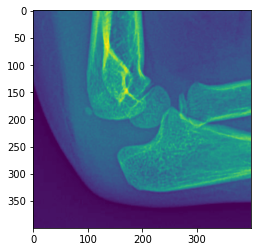

torch.Size([15, 1, 400, 400])
Label = 1 : Fracture image


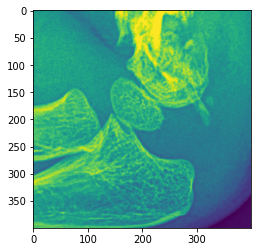

In [ ]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in valid_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

In [ ]:
# Build convolutional neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
           
            nn.Conv2d(1, 16, 3),  #396
            nn.ReLU(),
            nn.Conv2d(16,16, 3), #394
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #197

            nn.Conv2d(16, 32, 3),  #195
            nn.ReLU(),
            nn.Conv2d(32, 32, 3), #193
            nn.ReLU(),
            nn.MaxPool2d(2,2),   #96

            nn.Conv2d(32, 64, 3), #94
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), #92
            nn.ReLU(),
            nn.Conv2d(64, 64, 3), #90
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #45

        )
        
        self.fc = nn.Sequential(
            nn.Linear(45*45*64,64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x


model = Net()

In [ ]:
# Print the network you built
model.cuda()

Net(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=129600, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32

In [ ]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        print('Valid_Prediction : {}'.format(pred))
        print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 0 /39
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 50.802919708029194
Validation Accuracy : 50.63291139240506


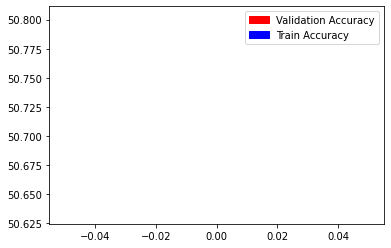

# Epoch : 1 /39
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 47.153284671532845
Validation Accuracy : 49.36708860759494


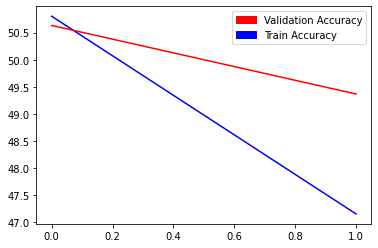

# Epoch : 2 /39
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 49.70802919708029
Validation Accuracy : 50.63291139240506


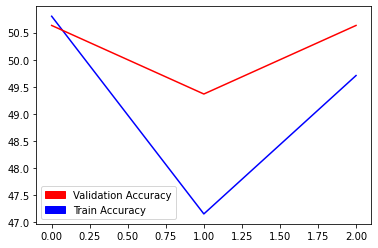

# Epoch : 3 /39
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 48.832116788321166
Validation Accuracy : 50.63291139240506


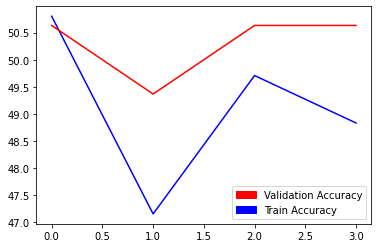

# Epoch : 4 /39
Valid_Prediction : [1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 51.67883211678832
Validation Accuracy : 55.69620253164557


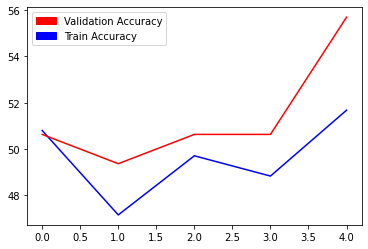

# Epoch : 5 /39
Valid_Prediction : [1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 54.23357664233577
Validation Accuracy : 55.69620253164557


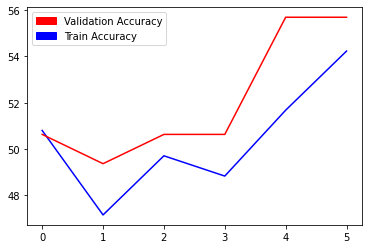

# Epoch : 6 /39
Valid_Prediction : [0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0 0 1 1 1 1 1 0 0 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 57.737226277372265
Validation Accuracy : 62.0253164556962


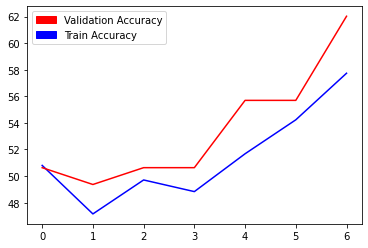

# Epoch : 7 /39
Valid_Prediction : [0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0 0 1 1 1 1 1 0 0 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 59.63503649635037
Validation Accuracy : 58.22784810126582


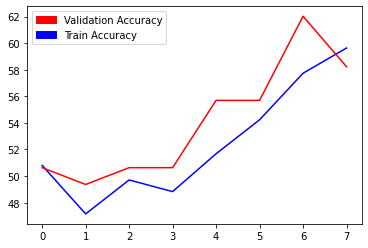

# Epoch : 8 /39
Valid_Prediction : [0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0 0 1 1 1 1 1 0 0 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 59.270072992700726
Validation Accuracy : 56.9620253164557


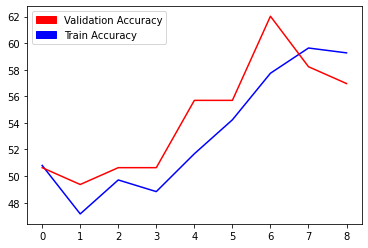

# Epoch : 9 /39
Valid_Prediction : [0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 59.270072992700726
Validation Accuracy : 59.49367088607595


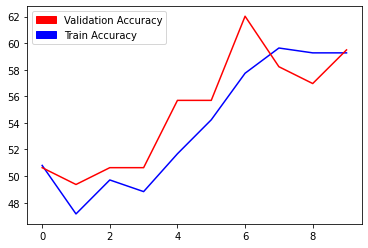

# Epoch : 10 /39
Valid_Prediction : [0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 60.0
Validation Accuracy : 59.49367088607595


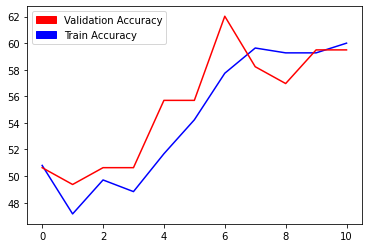

# Epoch : 11 /39
Valid_Prediction : [0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0 0 1 1 0 1 1 0 0 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 61.605839416058394
Validation Accuracy : 55.69620253164557


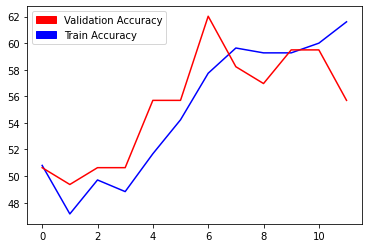

# Epoch : 12 /39
Valid_Prediction : [0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 0 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 60.58394160583942
Validation Accuracy : 58.22784810126582


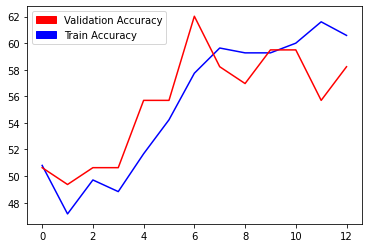

# Epoch : 13 /39
Valid_Prediction : [0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 60.43795620437956
Validation Accuracy : 59.49367088607595


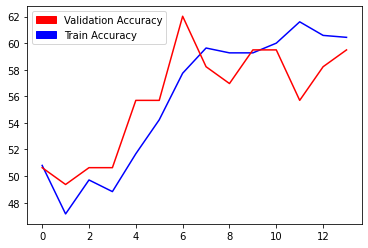

# Epoch : 14 /39
Valid_Prediction : [0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 62.11678832116788
Validation Accuracy : 58.22784810126582


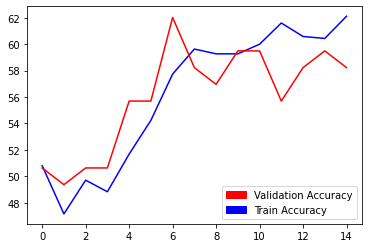

# Epoch : 15 /39
Valid_Prediction : [0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 62.55474452554745
Validation Accuracy : 56.9620253164557


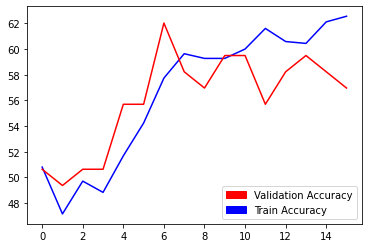

# Epoch : 16 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 0 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 62.84671532846715
Validation Accuracy : 59.49367088607595


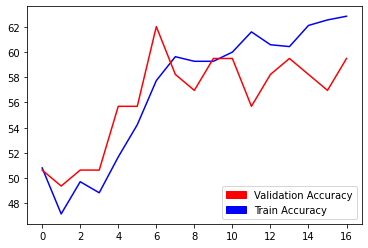

# Epoch : 17 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 0 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 63.21167883211679
Validation Accuracy : 58.22784810126582


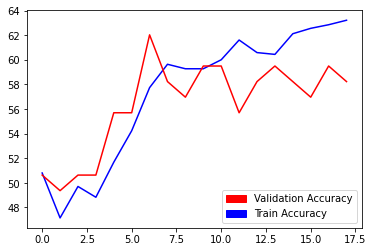

# Epoch : 18 /39
Valid_Prediction : [1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 64.52554744525547
Validation Accuracy : 58.22784810126582


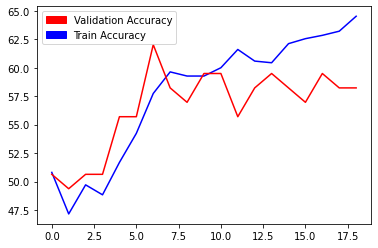

# Epoch : 19 /39
Valid_Prediction : [0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 65.1094890510949
Validation Accuracy : 59.49367088607595


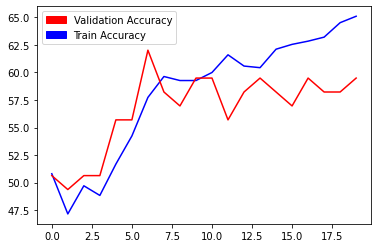

# Epoch : 20 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 0 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 63.357664233576635
Validation Accuracy : 63.29113924050633


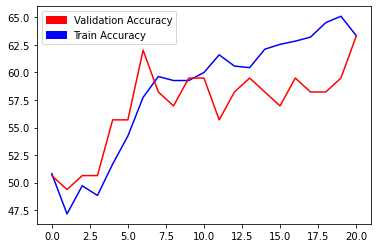

# Epoch : 21 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 0 1 0 0 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 63.649635036496356
Validation Accuracy : 64.55696202531645


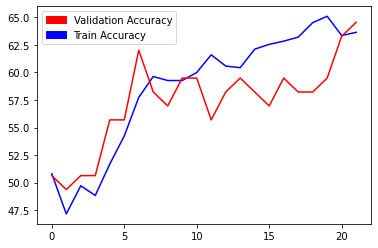

# Epoch : 22 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 65.32846715328468
Validation Accuracy : 63.29113924050633


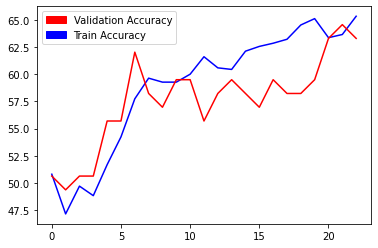

# Epoch : 23 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 1 0 0 0 1 0 0 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 63.21167883211679
Validation Accuracy : 60.75949367088608


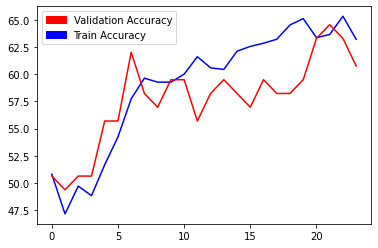

# Epoch : 24 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 0 1 1 0 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 64.81751824817519
Validation Accuracy : 62.0253164556962


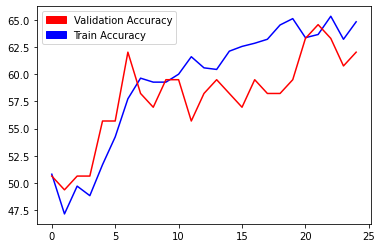

# Epoch : 25 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 65.54744525547446
Validation Accuracy : 63.29113924050633


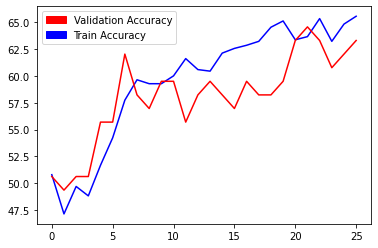

# Epoch : 26 /39
Valid_Prediction : [1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.86131386861314
Validation Accuracy : 62.0253164556962


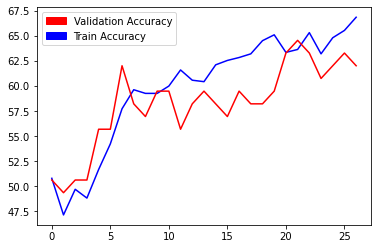

# Epoch : 27 /39
Valid_Prediction : [1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.05839416058394
Validation Accuracy : 60.75949367088608


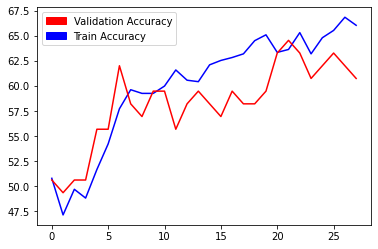

# Epoch : 28 /39
Valid_Prediction : [1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.2043795620438
Validation Accuracy : 62.0253164556962


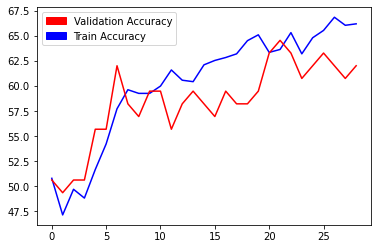

# Epoch : 29 /39
Valid_Prediction : [1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.73722627737226
Validation Accuracy : 62.0253164556962


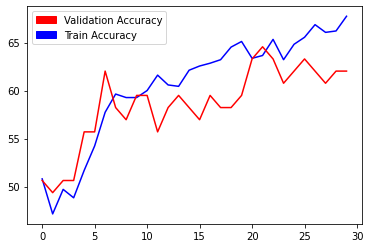

# Epoch : 30 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 66.64233576642336
Validation Accuracy : 65.82278481012658


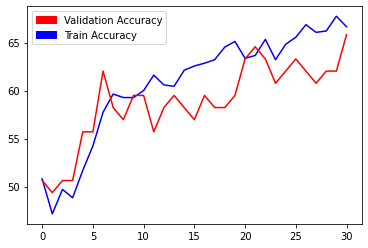

# Epoch : 31 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.08029197080292
Validation Accuracy : 68.35443037974683


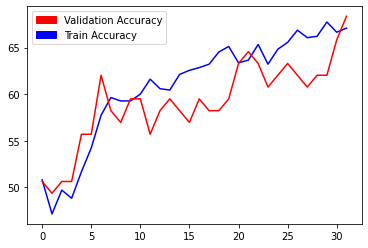

# Epoch : 32 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 67.37226277372262
Validation Accuracy : 67.08860759493672


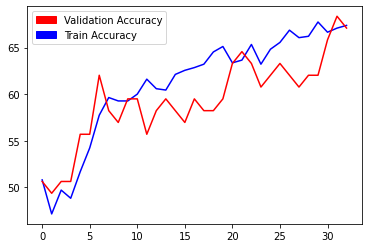

# Epoch : 33 /39
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0 0 0 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 68.75912408759123
Validation Accuracy : 65.82278481012658


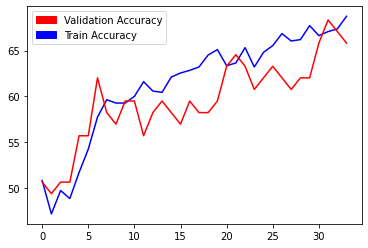

# Epoch : 34 /39
Valid_Prediction : [1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 70.36496350364963
Validation Accuracy : 64.55696202531645


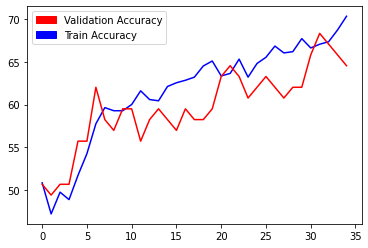

# Epoch : 35 /39
Valid_Prediction : [1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 1 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 68.68613138686132
Validation Accuracy : 62.0253164556962


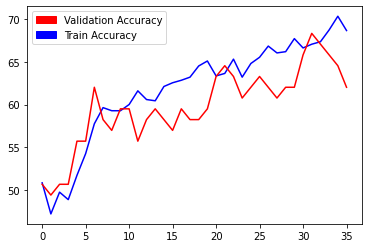

# Epoch : 36 /39
Valid_Prediction : [1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 1 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 70.0
Validation Accuracy : 63.29113924050633


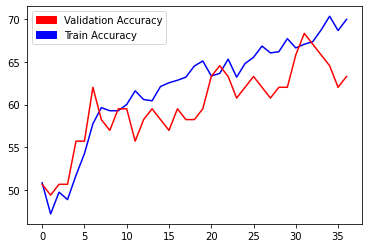

# Epoch : 37 /39
Valid_Prediction : [1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 0 1 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 69.7080291970803
Validation Accuracy : 55.69620253164557


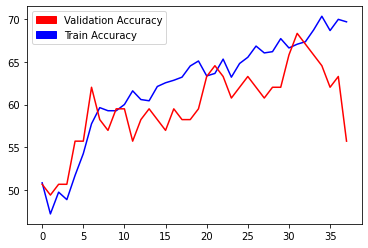

# Epoch : 38 /39
Valid_Prediction : [1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 69.85401459854015
Validation Accuracy : 64.55696202531645


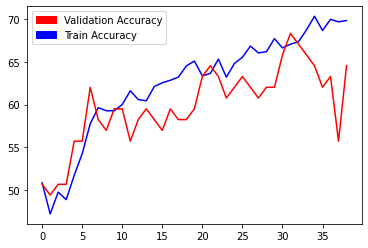

# Epoch : 39 /39
Valid_Prediction : [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1 0 1 1 1 1 1 0 1 0 0 0]
Valid_Truth : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train Accuracy : 70.5109489051095
Validation Accuracy : 70.88607594936708


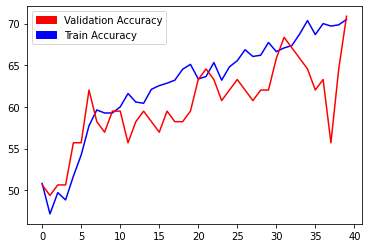

In [ ]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(40):
    print('# Epoch : {} /39'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/My Drive/PatternProject/Model_JiYe_1770027')